In [1]:
import sys
sys.path.append("C:/Users/haoyuan/Documents/GitHub/SpeckleContrastEstimation/")

import numpy as np
import time
import matplotlib.pyplot as plt

from ContrastEstimation import util, IntensityEstimation, ContrastEstimation, MoleculeZoo
from ContrastEstimation import ScatteringInfoMD 

# Define the incident beam

In [2]:
# Load the WAXS data
H2O_runs = [233,235,236,237,238,239,240,241,242,243,245,246,247]
H2O_temp = [ 30, 50, 75,100,125,150,175,200,225,250,300,325,350]

data_holder = []
for x in range(len(H2O_runs)):
    data_holder.append(np.loadtxt("C:/Users/haoyuan/Desktop/PosDoc/WaterContrastEstimation/"+
                                  "JupyterNotebook_v4/WAXS_data_complete/H2O_{}C_225bar_S{}_S227_sub.dat".format(H2O_temp[x], H2O_runs[x])))

In [3]:
my_density = 0.83 # g / ml

my_molecule = MoleculeZoo.molecule_zoo['H2O']
atten_length = IntensityEstimation.get_attenuation_length_cm(molecule_structure=my_molecule,
                                                             photon_energy_keV=15,
                                                             density=my_density)
atten_length *= 1e-2

In [4]:
photon_energy = 15.  # keV
I_in = 2.5  * 1e12  # incoming xray flux [photons/sec] at 14keV
l    = 0.42         # sample-to-detector distance [m]
p    = 172. *1e-6  # detector pixel size [m]
d    = 2.   *1e-3  # sample thickness [m]

# solid angle covered by a single detector pixel
omega = (p / l)**2 

# Get effective sampe thickness
d_eff = atten_length * (1 - np.exp( - d / atten_length))

# Get the scatterred intensity at the specified Q value
q_idx = np.argmin(np.abs(data_holder[-2][:,0] - 2.)) 
I_out = data_holder[-2][q_idx, 1]

print('The measured intensity is {:.2f}'.format(I_out))

The measured intensity is 169.36


# Get the corresponding curve with MD simulation

In [5]:
file_idx_list = np.arange(4000, 10001, 100)

In [6]:
tic = time.time()
(a_num,
 box_size,
 a_types,
 a_positions) = ScatteringInfoMD.load_atom_info(
    "C:/Users/haoyuan/Desktop/MD_output/atom.position.{}".format(4000))
toc = time.time()
print("It takes {:.2e} seconds to load the atom positions".format(toc - tic))

There are 6.84e+04 atoms in this file.
It takes 1.88e-01 seconds to load the atom positions


In [7]:
q_array_MD = np.linspace(0.1, 2.2, num=50)

q_array_complete = []
for q_idx in range(50):
    q_array_complete.append(
        ScatteringInfoMD.get_q_vector_list_in_range(box_size_xyz_A=box_size[:,1] - box_size[:,0],
                                                    q_low_A=q_array_MD[q_idx] - 0.01,
                                                    q_high_A=q_array_MD[q_idx] + 0.01))

length_list = np.array([0,] + [int(x.shape[0]) for x in q_array_complete], dtype=np.int64)
split_idx = np.cumsum(length_list)

q_array_complete = np.ascontiguousarray(np.concatenate(q_array_complete, axis=0))

In [8]:
output_intensity_holder = np.zeros((61, q_array_complete.shape[0]))

for file_idx in range(61):        
    # Loop through each file
    tic = time.time()
    (a_num,
     box_size,
     a_types,
     a_positions) = ScatteringInfoMD.load_atom_info(
        "C:/Users/haoyuan/Desktop/MD_output/atom.position.{}".format(file_idx_list[file_idx]))
    
    # Loop through all Q values
    MD_formfactor = ScatteringInfoMD.get_MD_formfactor_at_Q_list_parallel_at_Q(q_list_A=q_array_complete,
                                                                               atom_position_array=a_positions,
                                                                               atom_type_array=a_types,
                                                                               atom_type_name_list=["O", "H"])

    scattering_intensity = ScatteringInfoMD.get_diffracted_flux_with_MD_formfactor(in_flux=I_in,
                                                                                   dOmega=omega,
                                                                                   q_in=util.kev_to_wavevec_A(photon_energy),
                                                                                   d_eff_m = d_eff,
                                                                                   box_size_A = box_size,
                                                                                   q_list_A = q_array_complete,
                                                                                   formfactorMD = MD_formfactor)
    output_intensity_holder[file_idx, :] = np.copy(scattering_intensity)
    
    toc = time.time()
    print("It takes {:.2e} seconds to process 1 file".format(toc - tic))

There are 6.84e+04 atoms in this file.


C:\Users\haoyuan\anaconda3\envs\python38\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


It takes 3.49e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.41e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.40e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.49e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.47e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.32e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.22e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.35e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.30e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.28e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.30e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It takes 3.28e+00 seconds to process 1 file
There are 6.84e+04 atoms in this file.
It t

In [9]:
q_len_list = np.linalg.norm(q_array_complete,axis=-1)

q_len_bin = np.array([np.mean(q_len_list[split_idx[x]:split_idx[x+1]]) for x in range(50)])
mean_intensity_bin = np.array([np.mean(output_intensity_holder[:, split_idx[x]:split_idx[x+1]]) for x in range(50)])
std_intensity_bin = np.array([np.std(output_intensity_holder[:, split_idx[x]:split_idx[x+1]]) for x in range(50)])

In [10]:
areaMD = (box_size[0,1] - box_size[0,0]) * (box_size[1,1] - box_size[1,0]) * 1e-20
areaSample = (5e-6) * (5e-6)
ratio = areaSample / areaMD

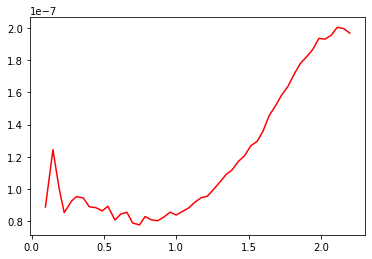

In [11]:
plt.plot(q_len_bin, mean_intensity_bin * ratio, 'r')
plt.show()

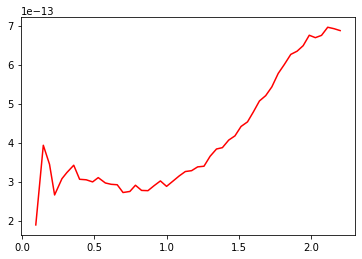

In [12]:
plt.plot(q_len_bin, std_intensity_bin, 'r')
plt.show()